The basic steps we'll take are:

Use DuckDuckGo to search for images of "bird photos"
Use DuckDuckGo to search for images of "forest photos"
Fine-tune a pretrained neural network to recognise these two groups
Try running this model on a picture of a bird and see if it works.


Imports

In [ ]:
# Forzamos un backend de Matplotlib compatible para este entorno
%matplotlib inline

# Para ventanas emergentes (pop-up) en lugar de inline
#import matplotlib as plt
#plt.use("TkAgg")

# Herramientas de busqueda (DuckDuckGo) y utilidades de vision de fastai
from ddgs import DDGS

from fastdownload import download_url
from fastai.vision.all import *

Download the images from DGGS (Duck go go searcher)

In [3]:
def search_images(keywords, max_images=50):
    """Consulta DuckDuckGo y devuelve URLs directas de imagenes."""
    with DDGS() as ddgs:
        results = ddgs.images(
            keywords,
            max_results=max_images
        )
        return [r["image"] for r in results]

# Ejemplo rapido: obtenemos algunas fotos de aves para explorar los datos
urls = search_images("bird photos", max_images=2)
print(urls[0])

https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg


In [4]:

# Descargamos una de las imagenes de ejemplo para inspeccionarla
dest = 'bird.jpg'
download_url(urls[1], dest, show_progress=True)


Path('bird.jpg')

Download the image and 

In [5]:
# Exploramos transformaciones rapidas sobre la imagen descargada
im = PILImage.create(dest)
im.to_thumb(256,256).show()      # thumbnail
(im.flip_lr()).show()            # voltear horizontal
(im.rotate(30)).show()           # rotacion ligera

im.shape  # dimensiones originales



(2832, 4256)

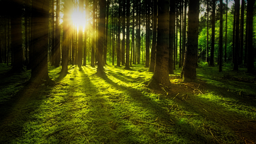

In [6]:
# Guardamos una imagen de bosque para usarla como ejemplo negativo
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [7]:
searches = 'forest','bird','cat','dog'
path = Path('bird_or_not')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    time.sleep(5)
    resize_images(path/o, max_size=400, dest=path/o)


In [8]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

To train a model, we'll need DataLoaders, which is an object that contains a training set (the images used to create a model) and a validation set (the images used to check the accuracy of a model -- not used during training). In fastai we can create that easily using a DataBlock, and view sample images from it:

DataBlock es una manera flexible de definir cómo quieres preparar tus datos. Es como una receta que le dice a fastai: Qué tipo de datos estás usando (imágenes, etiquetas, texto, etc.). Cómo obtenerlos. Cómo dividirlos en entrenamiento y validación. Cómo transformarlos.

1. blocks=(ImageBlock, CategoryBlock)

    - Esto le dice a fastai:

    - ImageBlock: las entradas (X) son imágenes.

    - CategoryBlock: las salidas (Y) son categorías (por ejemplo, "perro", "gato", "bosque", etc.).

2. get_items=get_image_files

    - Esto le dice a fastai cómo obtener las imágenes desde el directorio que le pases más adelante (path).

    - get_image_files busca todos los archivos de imagen (.jpg, .png, etc.) dentro del directorio y sus subcarpetas.

3. splitter=RandomSplitter(valid_pct=0.2, seed=42)

    - Esto define cómo se divide tu conjunto de datos en:

    - Entrenamiento (80%)

    - Validación (20%)

        - valid_pct=0.2 → usa el 20% de las imágenes para validación.
        - seed=42 → asegura que la división sea siempre igual (útil para reproducir resultados).

    💡 La validación sirve para evaluar cómo de bien generaliza tu modelo con datos que no ha visto durante el entrenamiento.

4. get_y=parent_label

    Esto le dice a fastai cómo obtener la etiqueta (Y) de cada imagen.

    🗂️ parent_label significa que la etiqueta es el nombre de la carpeta donde está la imagen.
    
5.  item_tfms=[Resize(192, method='squish')]

    El comando item_tfms=[Resize(192, method='squish')] está redimensionando todas las imágenes a un tamaño fijo de 192x192 píxeles, deformándolas si es necesario para que encajen exactamente en ese tamaño(squish). Esto se hace porque los modelos de deep learning necesitan que todas las imágenes tengan el mismo tamaño para poder procesarlas en lotes de manera eficiente y sin errores. Redimensionar también reduce la carga computacional, haciendo el entrenamiento más rápido y manejable.


Un DataLoader es un objeto que contiene el conjunto de datos ya preparado (imágenes + etiquetas), listo para ser:
Entregado al modelo por lotes (batches).
Con las transformaciones aplicadas (como Resize).
Y dividido en entrenamiento y validación.

In [9]:
# Imprime esto para verificar
print(path)
print(list(path.ls()))

bird_or_not
[Path('bird_or_not/bird'), Path('bird_or_not/cat'), Path('bird_or_not/dog'), Path('bird_or_not/forest')]


In [10]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)
# Nota: bs es el tamaño del lote (batch size) y debe ser menor o igual al número de imágenes en tu conjunto de entrenamiento.





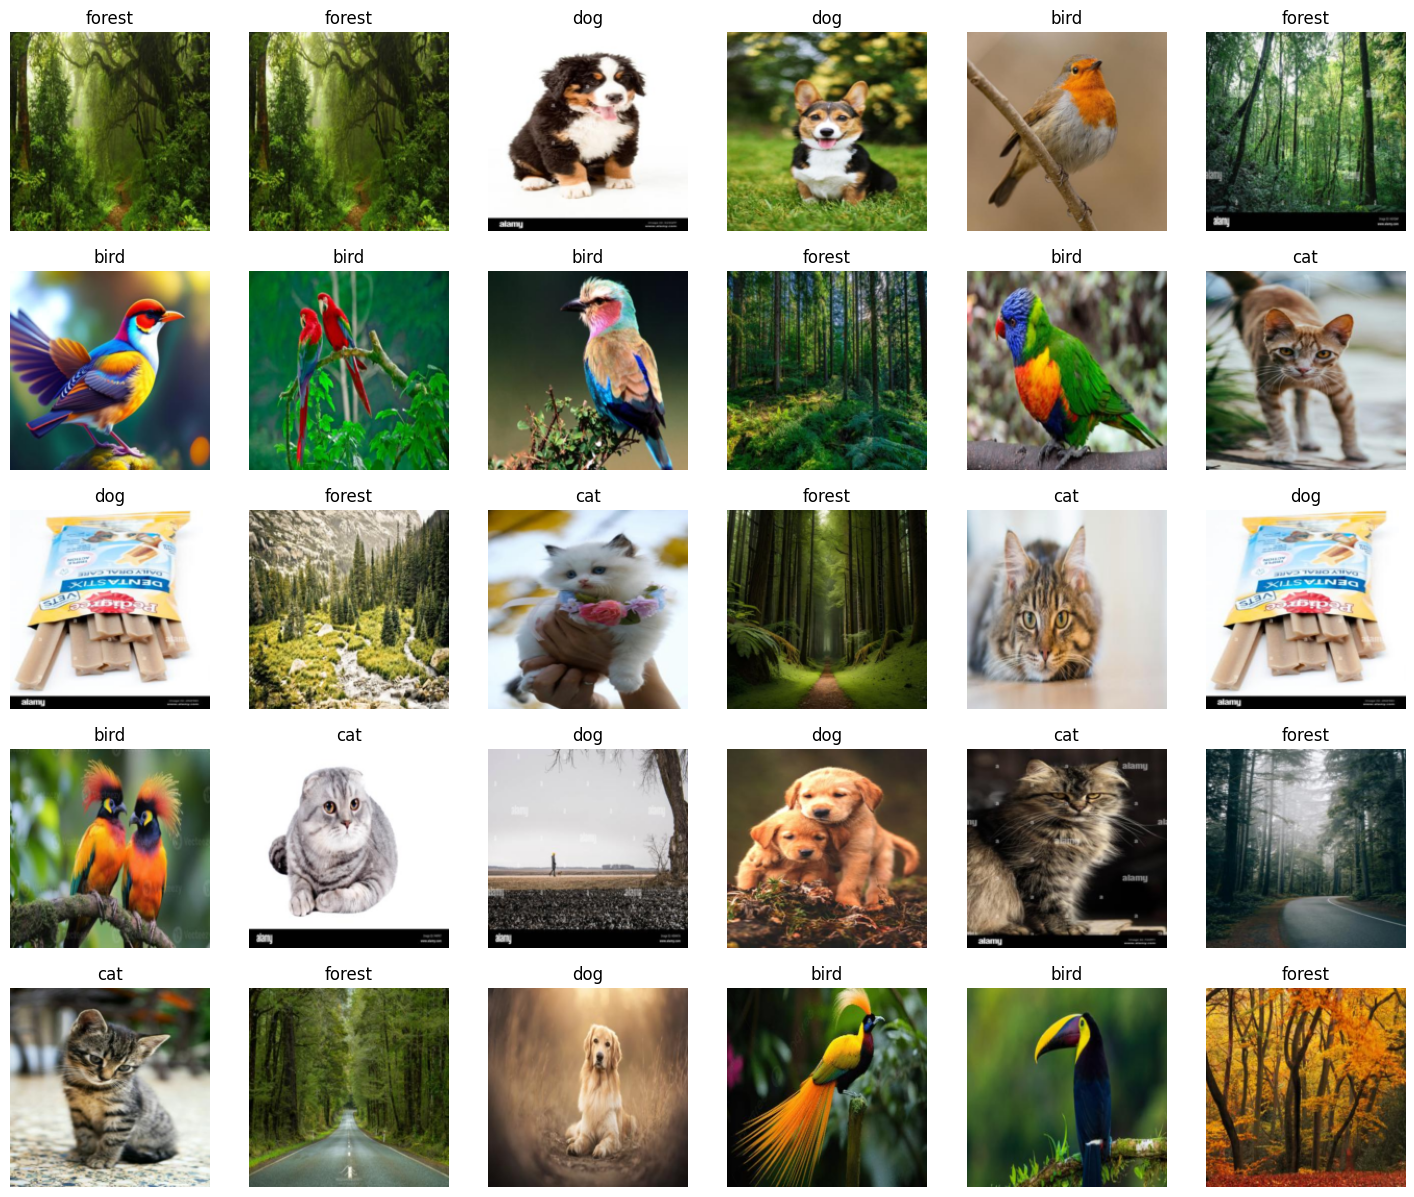

In [11]:
dls.show_batch(max_n=30)
plt.show()

In [ ]:
#TÚ creas el modelo (con weights iniciales)
learn = vision_learner(dls, resnet18, metrics=error_rate)
# "Crea una red con weights aleatorios"

# 3. TÚ dices "aprende" 🔥 AQUÍ PASA TODO
learn.fine_tune(3)  # entrenamos 3 epocas
# El modelo automáticamente:
# - Hace predicciones
# - Calcula errores
# - AJUSTA LOS WEIGHTS (miles de veces)
# - Repite hasta mejorar

# 4. TÚ usas el modelo entrenado
print(learn.model)


epoch,train_loss,valid_loss,error_rate,time
0,1.312609,0.427234,0.083333,00:12


epoch,train_loss,valid_loss,error_rate,time
0,0.214363,0.369828,0.072917,00:15
1,0.128332,0.323847,0.072917,00:15
2,0.084502,0.341896,0.072917,00:15


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

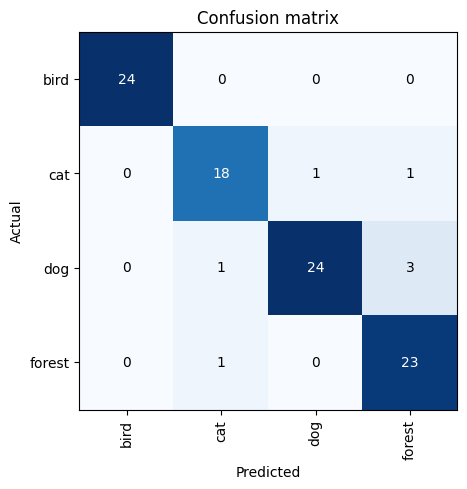

In [13]:
# Confusion matrix

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
# Quick uploader: guarda y muestra automáticamente la imagen subida
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
import io

# Crea el uploader y lo muestra
uploader = widgets.FileUpload(accept='image/*', multiple=False)
display(uploader)

# Guarda bytes de imagen a fichero usando PIL
def save_uploaded_image_bytes(content_bytes, dest_fname='uploaded_image.png'):
    img = Image.open(io.BytesIO(content_bytes))
    img.save(dest_fname)
    return dest_fname

# Handler: se ejecuta cuando cambia uploader.value
def handle_upload(change):
    # obtén el valor actual del uploader
    val = uploader.value
    if not val:
        return
    # extrae bytes del primer archivo (varios formatos según ipywidgets)
    try:
        # formato habitual: {filename: {'content': b'...', ...}}
        item = next(iter(val.values()))
        content = item.get('content') if isinstance(item, dict) else None
        name = item.get('metadata', {}).get('name') if isinstance(item, dict) else None
        # algunos formatos usan 'name' directamente
        if not name:
            name = item.get('name') if isinstance(item, dict) else None
    except Exception:
        # fallback: val puede ser lista/tuple
        if isinstance(val, (list, tuple)) and len(val) > 0:
            entry = val[0]
            content = entry.get('content') if isinstance(entry, dict) else entry[
] if isinstance(entry, (list, tuple)) else None
            name = entry.get('name') if isinstance(entry, dict) else None
        else:
            print('Formato inesperado en uploader.value:', type(val))
            return
    if content is None:
        print('No se pudieron obtener los bytes del archivo subido.')
        return
    fname = name or 'uploaded_image.png'
    save_uploaded_image_bytes(content, fname)
    # Muestra el uploader y la imagen guardada
    clear_output(wait=True)
    display(uploader)
    display(Image.open(io.BytesIO(content)))
    print(f'Imagen guardada como: {fname}')

# Conecta el handler para que se ejecute automáticamente
uploader.observe(handle_upload, names='value')

# Si ya había archivos subidos (p. ej. al recargar), puedes forzar el handler:
# if uploader.value: handle_upload(None)


FileUpload(value=(), description='Upload')

In [14]:
# Evaluamos el modelo con una imagen de bosque preparada antes
is_bird,_,probs = learn.predict(PILImage.create('forest.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")
print(f"Probability it's a forest: {probs[1]:.4f}")
print(f"Probability it's a cat: {probs[2]:.4f}")
print(f"Probability it's a dog: {probs[3]:.4f}")


This is a: forest.
Probability it's a bird: 0.0001
Probability it's a forest: 0.0008
Probability it's a cat: 0.0286
Probability it's a dog: 0.9705
